# Trajectory aggregation

Sometimes, when you have many real-data trajectories, you want to detect the return trips. This tutorial is going to show how to split and reverse one half of it in order to keep the same directions for all the trajectories. The algorithm is based on the comparison of trajectories: the return point corresponds to the point which divides the trace in two and whose distance between the two is the smallest. In tracklib, the function to do this is:
<br/>
<div class="alert alert-block alert-info" style="padding:1em">
    
```python
  collection = tkl.splitReturnTripExhaustive(trace)
```

</div>

## As usual, let's start by defining our environment

The first task is only useful for the online notebook and import the local tracklib code source. It's not necessary if tracklib is installed from PyPI.

In [1]:
import os
import sys

# Import de tracklib
module_path = os.path.abspath(os.path.join('../../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The following two imports are necessary for the tutorial:

In [2]:
# Matplotlib to create visualizations
import matplotlib.pyplot as plt

# Import tracklib library
import tracklib as tkl

## Loading a collection of tracks

In [3]:
srid = 'ENUCoords'

# ==============================================================================
# ==============================================================================
#   On charge les traces
tkl.ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")
PATH = '/home/md_vandamme/tracklib/fusion/DATA/0_ECHELLE/'
collection = tkl.TrackReader.readFromGpx(path=PATH, srid='GEO', type='trk')
print ('Number of tracks: ' + str(collection.size()))
collection.toENUCoords(2154)

Number of tracks: 20


##   On découpe les traces

In [4]:
Xmin = 991219   # 991208
Ymin = 6478438
Xmax = 991901   # 992778
Ymax = 6478875

ll = tkl.ENUCoords(Xmin, Ymin)
ur = tkl.ENUCoords(Xmax, Ymax)
bbox = tkl.Rectangle(ll, ur)

constraintBBox = tkl.Constraint(shape = bbox, mode = tkl.MODE_INSIDE,
                                type=tkl.TYPE_CUT_AND_SELECT)
selections = constraintBBox.select(collection)
print (selections.size(), ' traces sélectionnées dans emprise')
collection = selections

20  traces sélectionnées dans emprise


On découpe suivant le point qui optimise l'écart entre deux morceaux de la trace

In [5]:
collection2 = tkl.TrackCollection()
for trace in collection:
    SPLITS = tkl.splitReturnTripExhaustive(trace, verbose=False)
    #print (collection4.size())
    t1 = SPLITS[0]
    t2 = SPLITS[1]
    d = tkl.compare(t1, t2, tkl.MODE_COMPARISON_AREAL)

    if d < 5:
        collection2.addTrack(t1)
        collection2.addTrack(t2)

    else:
        # On ne découpe pas
        collection2.addTrack(trace)

TREF = collection2[0]
collection3 = tkl.TrackCollection()
for t in collection2:
    d1 = tkl.compare(TREF, t, verbose=False, mode=tkl.MODE_COMPARISON_DTW, p=1)
    d2 = tkl.compare(TREF, t.reverse(), verbose=False, mode=tkl.MODE_COMPARISON_DTW, p=1)

    # A l'envers
    if (d2 < d1):
        t = t.reverse()
        collection3.addTrack(t)
    else:
        collection3.addTrack(t)

print ('Number of tracks: ', collection3.size())
print 

plt.figure(figsize=(7, 7))
for t in collection3:
    t.plot('c-', append=True)
    t.plotFirstObs(color='g', text='', append=True)

Number of tracks:  29



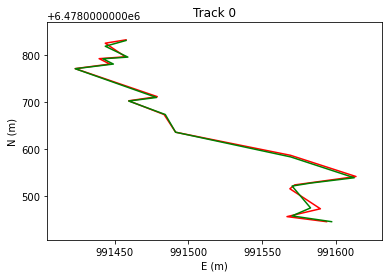

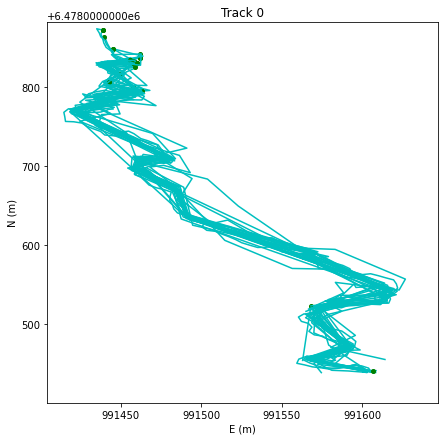

In [6]:
master = tkl.MODE_MASTER_MEDIAN_LEN
p = 2
mode = tkl.MODE_MATCHING_DTW  # MODE_MATCHING_FRECHET
represent_method = tkl.MODE_REP_BARYCENTRE
agg_method = tkl.MODE_AGG_MEDIAN
constraint = False

central = tkl.fusion(collection3,
                     master=master, dim=2,
                     mode=mode, p=p,
                     represent_method=represent_method, 
                     agg_method=agg_method,
                     constraint=constraint, 
                     verbose=False, 
                     iter_max=100)
central.plot('r-')
#QGIS.plotTracks(central, type='LINE', style=LineStyle.simpleRed, title='centralDTW')


mode = tkl.MODE_MATCHING_FRECHET
central2 = tkl.fusion(collection3,
                     master=master, dim=2,
                     mode=mode, p=p,
                     represent_method=represent_method, 
                     agg_method=agg_method,
                     constraint=constraint, 
                     verbose=False, 
                     iter_max=100)
#QGIS.plotTracks(central2, type='LINE', style=LineStyle.simpleLightOrange, title='central Frechet')
central2.plot('g-')

plt.figure(figsize=(7, 7))
for t in collection3:
    t.plot('c-', append=True)
    t.plotFirstObs(color='g', text='', append=True)